Find local communities

In [1]:
import sys
import networkx as nx
import numpy as np
import copy

# density function is defined as 2*number of edges in a cluster / number of vertices in the cluster
def density(g):
    length = len(list(g.nodes()))
    if length == 0:
        return 0.0
    return float(sum(map(lambda x: x[1], g.degree())))/length

# generates a networkx graph from edge list
def generate_graph(filename):
    with open(filename, 'rb') as inf:
        next(inf, '')   # skip a line
        G = nx.read_edgelist(inf, delimiter=" ", nodetype=str)
    return G

# Link aggregate algorithm as per paper 1
def LA(G):
    list_of_vertices = G.nodes()
    page_rank_dict = nx.pagerank(G)
    page_rank_dict = sorted(page_rank_dict.items(), key=lambda x: x[1], reverse =True)
    clusters = []
    for v_row in page_rank_dict:
        added = False
        for i,D in enumerate(clusters):
            w = density(G.subgraph(D))
            W = density(G.subgraph(D+[v_row[0]]))
            if W > w:
                clusters[i] = D+[v_row[0]]
                added = True
        if added == False:
            clusters.append([v_row[0]])
    return clusters

# IS_square algorithm as per paper 1
def IS_square(seed,G):
    C = list(set(seed))
    w = density(G.subgraph(C))
    increased = True
    while increased:
        N = copy.deepcopy(C)
        for v in C:
            N = N + list(G.neighbors(v))
            N = list(set(N))
        for v in N:
            c_dash = copy.deepcopy(C)
            if v in C:
                c_dash.remove(v)
            else:
                c_dash = C + [v]
                #C = C + [v]
            if density(G.subgraph(c_dash)) > density(G.subgraph(C)):
                C = c_dash
        if density(G.subgraph(C)) <= w:
            increased = False
        else:
            w = density(G.subgraph(C))
    return C

# write the output i.e. the identified (overlapping) clusters to a file
def write_to_file(filename, new_cluster):
    fo = open(filename, "w+")
    for c in new_cluster:
        fo.write(" ".join(c))
        fo.write("\n")
    fo.close()

# checks if a cluster formed is already present in the output.
def is_duplicate(new_clus, new_clusters):
    for v in new_clusters:
        if len(set(new_clus).difference(set(v))) == 0:
            return True
    return False


filename = "datasets/youtube/youtube.graph.small"
G = generate_graph(filename)
clusters = LA(G)
new_clusters = []
for seed in clusters:
    new_clus = IS_square(seed,G)
    if not is_duplicate(new_clus, new_clusters):
        new_clusters.append(new_clus)
write_to_file(filename.split("/")[2] + "_output.txt", new_clusters)
print "DONE."

DONE.


Create positions for nodes and edges

In [2]:
pos = nx.spring_layout(G)

Visualize Graphs

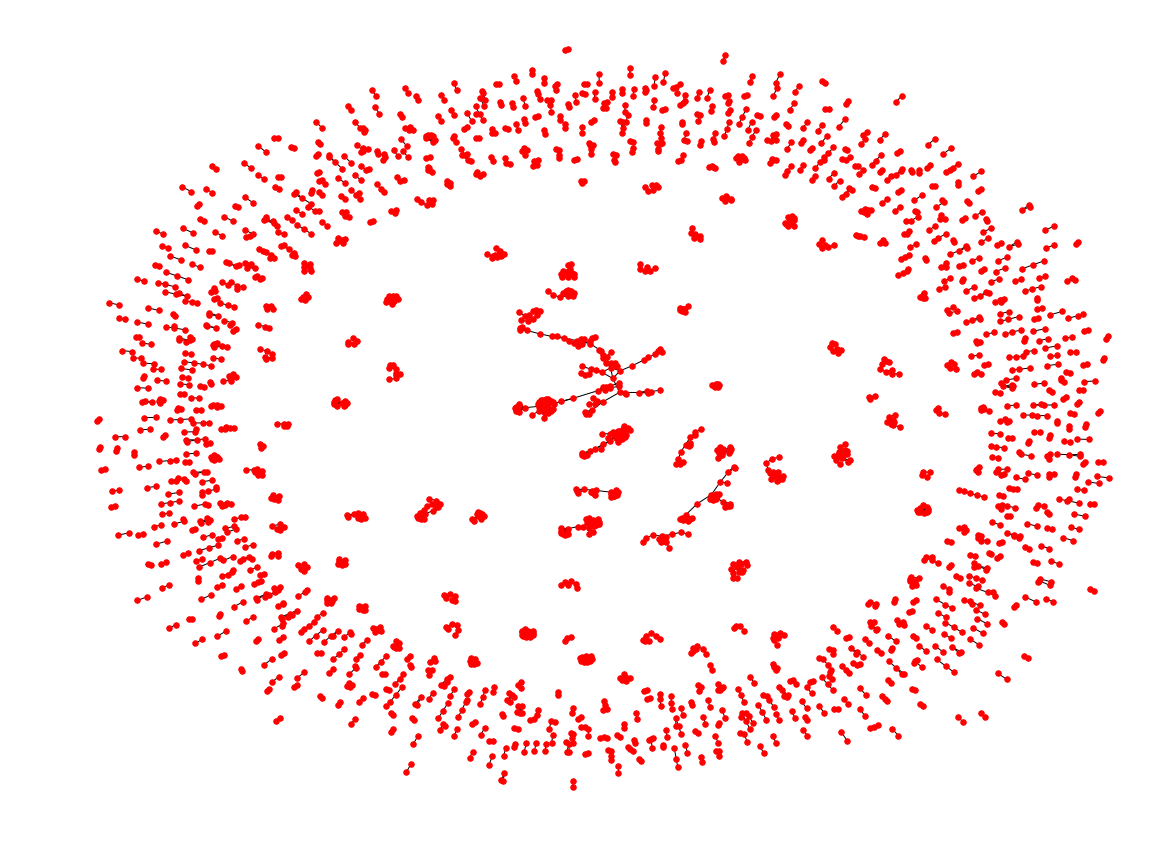

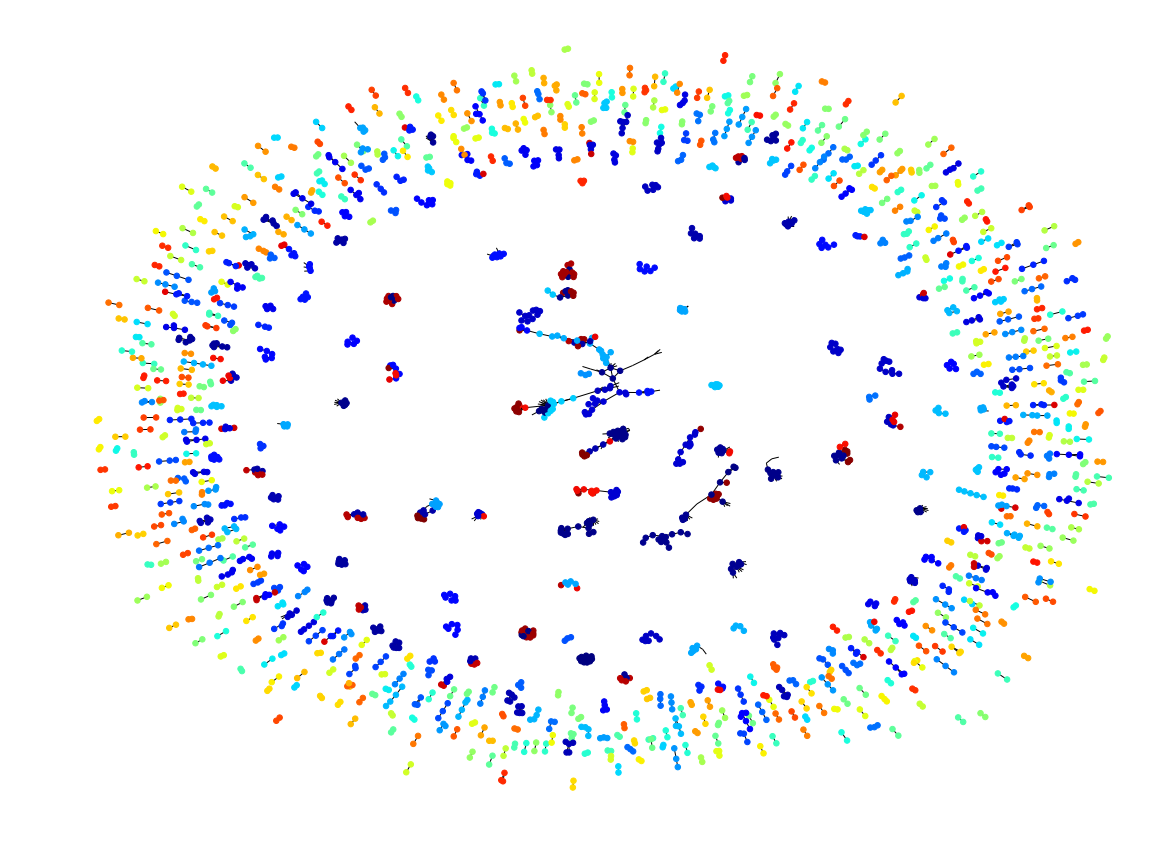

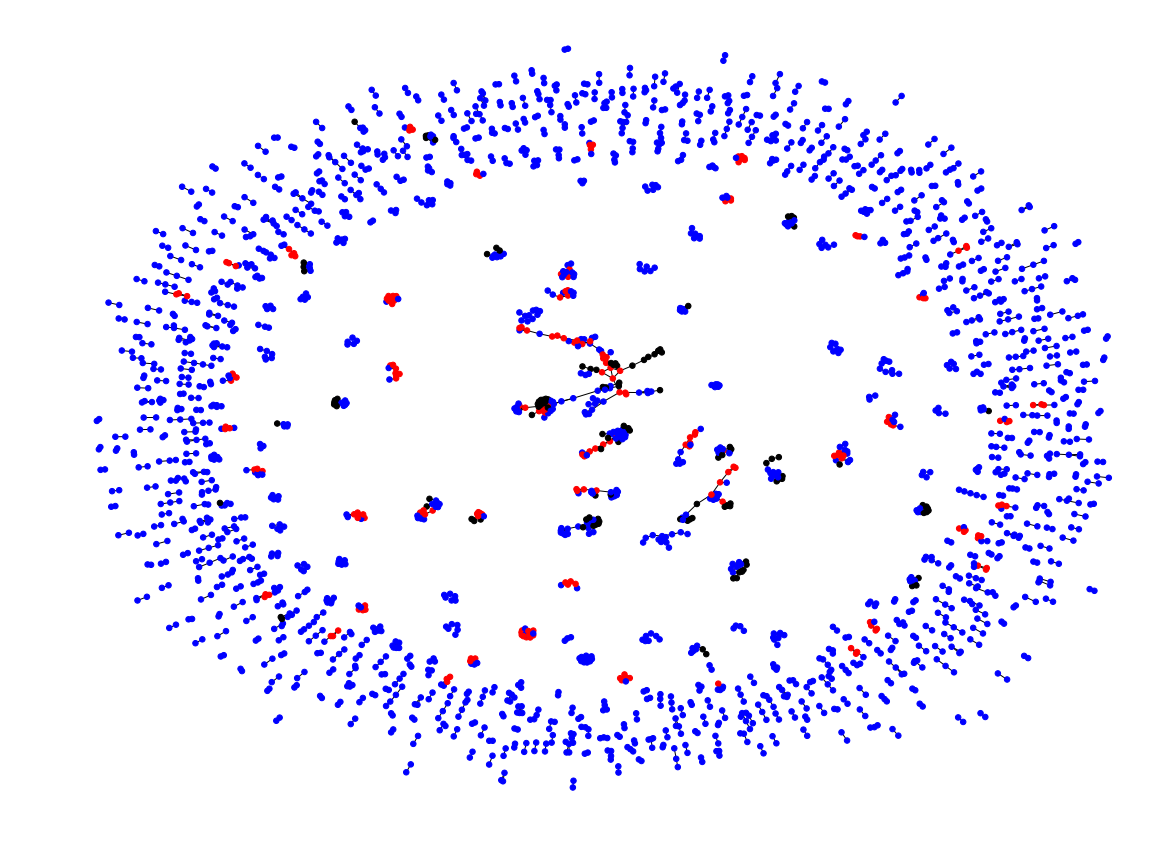

In [4]:
import matplotlib.pyplot as plt

def groupColor(node, clusters):
    for i,m in enumerate(clusters):
        if node in m:
            return float(i)/len(clusters)

def multipleGroups(node, clusters):
    group = 0
    numGroups = 0
    for i,m in enumerate(clusters):
        if node in m:
            numGroups += 1
            group = 'b'
    if numGroups > 1:
        group = 'r'
    return group

colors = []
colorsMul = []
for n in G.nodes:
    colors.append(groupColor(n, new_clusters))

for n in G.nodes:
    colorsMul.append(multipleGroups(n, new_clusters))
    
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=30)
plt.axis("off")
plt.show()
    
plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),node_color=np.array(colors), node_size=30)
plt.axis("off")
plt.show()

plt.figure(figsize=(20,15))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos,node_color=np.array(colorsMul), node_size=30)
plt.axis("off")
plt.show()